In [ ]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import random as rd
from numpy.fft import *
import scipy.io

rd.seed(10)

In [ ]:
''' Useful functions
'''

def distance(pos1, pos2):
    """Calculate Euclidean distance between two positions."""
    return np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

def gaussian_vortex(x, y, x0, y0, amplitude, sigma):
    """Generate a 2D Gaussian vortex of given amplitude and radius"""
    return amplitude * np.exp(-((x - x0)**2 + (y - y0)**2) / (2 * sigma**2))

def rankine_vortex(x, y, x0, y0, amplitude, sigma):
    """Generate a 2D Rankine vortex of given amplitude and radius"""
    xx,yy = np.meshgrid(x,y)
    return amplitude * (np.sqrt((xx - x0)**2 + (yy - y0)**2) <= sigma )


def random_vortex_placing(xx, yy, N, amplitude, sigma, margin, type_vortex = 'gaussian'):
    """ Randomly positions N dipoles of vortices of opposite signs in the (x,y) field
        N: number of vortices
        amplitude, sigma: gaussian parameters 

    """
    if N % 2 == 1:
        sys.exit("Not a dipole. Choose even number")
    ### initialization
    # output field
    Nx, Ny = np.shape(xx)
    vorticity_field = np.zeros((Nx,Ny))
    # sampling pool
    lx = xx[0,:]
    mask = np.zeros((Nx, Ny), dtype=bool)

    # margin around border, then with periodicity it will properly fill the borders 
    grid_margin = (xx**2 + yy**2 <= (margin*sigma/2)**2)
    halo_cells = int(np.sqrt(len(grid_margin.nonzero()[0])))
    mask[halo_cells:Nx-halo_cells,halo_cells:Ny-halo_cells] = True
    pooly, poolx = mask.nonzero() 
    # for loop
    sgn = 1
    for vortex in range(N):
        # check if current vortex density allows no overlap
        Npool = len(poolx)
        if Npool<=4*sigma*margin*Nx/(2*np.pi):
           sys.exit("Not enough space for number of dipoles")
           return
        rd_pair_index = rd.choice(range(Npool))
        xn, yn = lx[poolx[rd_pair_index]], lx[pooly[rd_pair_index]]
        if type_vortex == 'gaussian':
            vorticity_field+= gaussian_vortex(xx, yy, xn, yn, sgn*amplitude, sigma)
        elif type_vortex == 'rankine':
            vorticity_field+= rankine_vortex(xx, yy, xn, yn, sgn*amplitude, sigma)
        
        # vectorized for performance
        distance_sq = (xx - xn)**2 + (yy - yn)**2
        mask &= distance_sq > (sigma * margin)**2

        pooly, poolx = mask.nonzero() 
        sgn *= -1
       
    return vorticity_field


def handle_periodicity(array):
    
    resol = np.shape(array)[0]
    periodic_array = np.zeros((3 * resol , 3 * resol))

    # Array at center
    periodic_array[resol:2 * resol, resol:2 * resol] = array

    # Use np.roll to fill the periodic boundaries
    periodic_array[:resol, resol:2 * resol] = np.roll(array, shift=-resol, axis=0)  # Top
    periodic_array[2 * resol:, resol:2 * resol] = np.roll(array, shift=resol, axis=0)  # Bottom
    periodic_array[resol:2 * resol, :resol] = np.roll(array, shift=-resol, axis=1)  # Left
    periodic_array[resol:2 * resol, 2 * resol:] = np.roll(array, shift=resol, axis=1)  # Right

    # Fill the corners
    periodic_array[:resol, :resol] = np.roll(array, shift=(-resol, -resol), axis=(0, 1))  # Top-left
    periodic_array[:resol, 2 * resol:] = np.roll(array, shift=(-resol, resol), axis=(0, 1))  # Top-right
    periodic_array[2 * resol:, :resol] = np.roll(array, shift=(resol, -resol), axis=(0, 1))  # Bottom-left
    periodic_array[2 * resol:, 2 * resol:] = np.roll(array, shift=(resol, resol), axis=(0, 1))  # Bottom-right

    # The center of the array is the periodic part of the field
    periodic_field = periodic_array[resol//2:3 * resol//2,resol//2:3 * resol//2]

    return periodic_field

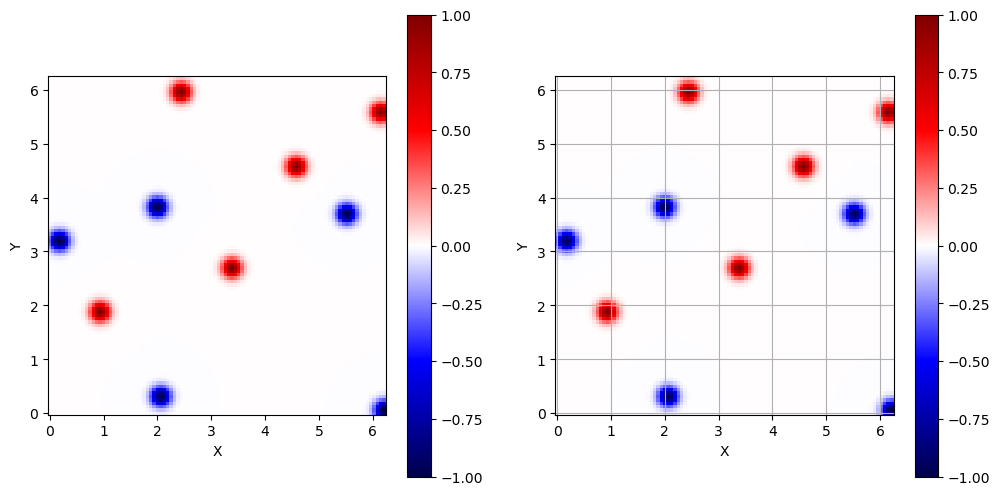

In [ ]:
np.shape(periodic_field)


fig, (ax1, ax2) = plt.subplots(1,2,figsize = (12,6))
im1 = ax1.pcolor(xx, yy, vort, cmap='seismic')
ax1.set_aspect('equal', 'box')
cbar1 = plt.colorbar(im1, ax=ax1)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
plt.grid()
im2 = ax2.pcolor(xx, yy, periodic_field, cmap='seismic')
ax2.set_aspect('equal', 'box')
cbar2 = plt.colorbar(im2, ax=ax2)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
plt.grid()

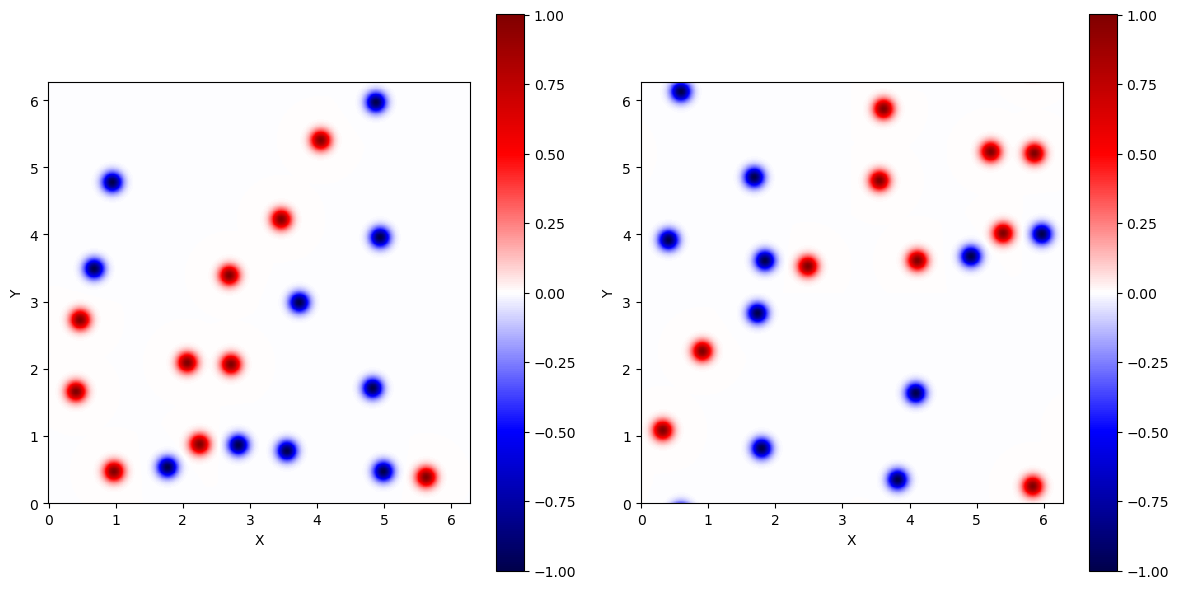

In [ ]:
resol = 1024
N = 500
kr = 100
amplitude = 1
sigma = 0.01#2*np.pi/kr# rcore = L/100
margin = 5

resol = 512
N = 20
kr = 20
amplitude = 1
sigma = 0.1#2*np.pi/# rcore = L/100
margin = 5

# grid definition
lx = np.linspace(0, resol - 1, resol) * 2*np.pi/resol
xx,yy = np.meshgrid(lx,lx)

# grid definition
lx = np.linspace(0, 2*resol - 1, 2*resol) * 2*np.pi/(2*resol)
xx2,yy2 = np.meshgrid(lx,lx)

vort = random_vortex_placing(xx, yy, N, amplitude, sigma, margin)
periodic_vort = handle_periodicity(vort)
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (12,6))
im1 = ax1.pcolor(xx, yy, vort, cmap='seismic')
ax1.set_aspect('equal', 'box')
cbar1 = plt.colorbar(im1, ax=ax1)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
im2 = ax2.pcolor(xx, yy, periodic_vort, cmap='seismic')
ax2.set_aspect('equal', 'box')
cbar2 = plt.colorbar(im2, ax=ax2)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')

plt.tight_layout()  
plt.show()

In [ ]:
import scipy.io

# generate N realizations of random field
resol = 1024
N = 500
kr = 200
amplitude = 1
sigma = 0.01
margin = 5

# grid definition
lx = np.linspace(0, resol - 1, resol) * 2*np.pi/resol
xx,yy = np.meshgrid(lx,lx)

for n in range(Nexp):    
    vort = random_vortex_placing_speedup(xx, yy, N, amplitude, sigma, margin)
    periodic_vort = handle_periodicity(vort)
    # save data
    vort_field = {
        'zeta': periodic_vort,
        'rcore': sigma,
        'margin': margin,
        'N':N
    }
    # Save the data to a .mat file
    scipy.io.savemat('N500_1024_kr100/sample_'+str(n)+'_1024_kr100_N500.mat', vort_field)